# Train Demo Model

This notebook shows an example of how to train, evaluate, and save a model to predicted expected goals from match and stadium data.

In [6]:
%matplotlib inline

In [7]:
import sys
sys.path.append("../")

from haxml.utils import (
    get_matches_metadata,
    get_stadiums,
    get_opposing_goalpost,
    load_match,
    is_target_stadium,
    is_scored_goal,
    total_scored_goals,
    total_kicks,
    goal_fraction,
    stadium_distance,
    angle_from_goal,
    train_test_split_matches_even_count
)

from haxml.viz import (
    plot_positions
)

import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Split Train/Test Data

Choosing a train/test split is an important aspect of training ML models.

- We want to have enough data to train and test our model.
- We want both splits to be representative of what the model will encounter in production.
- We want the target variable to have similar frequency in both the train and test data.
- We do not want to leak information about the test data into the train data.

Read, execute, and understand how we make this train/test split in the cells below. What are some things that are good and bad about how we are splitting the data?

In [8]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")

The full, inflated match records contain the players' positional data, which can become quite large if we load them all at once. To be more efficient with memory, we have a file of match metadata records, providing us basic information that we can use to split train/test data and to evaluate models, without loading the full match data.

The memory savings allow us to do this analysis from the comfort of a Jupyter notebook without needing much more computing power.

Check out an example of the metadata for one match. Note that "scored goals" can differ from the actual score. We don't consider own-goals as scored goals (only errors, which are shots from an offensive player that deflect off of defenders), since the offense did not directly produce them.

We will build a model to predict offensive XG. But XG is also used as a defensive metric. Own goals are one reason a defense may give up more goals than XG predicts.

In [6]:
metadata[26]

{'match_id': '-MPG8aVg406bTT1daesR',
 'stadium': 'NAFL 1v1/2v2 Map v1',
 'time': 106.8,
 'kicks_red': 21,
 'kicks_blue': 30,
 'score_red': 3,
 'score_blue': 2,
 'scored_goals_red': 2,
 'scored_goals_blue': 2}

Our `haxml.utils` module has one method for split matches into train and test data. You can check the docstring of a method by calling `help()`. Let's see what this one does.

In [7]:
help(train_test_split_matches_even_count)

Help on function train_test_split_matches_even_count in module haxml.utils:

train_test_split_matches_even_count(metadata)
    Evenly splits matches into train and test lists of almost the same size.
    Matches are sorted by number of scored goals, in an attempt to evenly
    distribute scored goals between the two lists.
    Args:
        metadata: List of dicts with IDs and metadata for each match, to split
            into train and test lists.
    Returns:
        (train, test): Tuple containing match IDs for train and test splits
            (lists of strings).



In [8]:
train, test = train_test_split_matches_even_count(metadata)

In [9]:
def summarize_split(metadata):
    """
    Helper method to summarize a train/test split.
    Args:
        metadata: Match metadata for one split (list of dicts).
    """
    goals = sum(total_scored_goals(m) for m in metadata)
    kicks = sum(total_kicks(m) for m in metadata)
    frac = goal_fraction(goals, kicks)
    print("Matches: {:,}".format(len(metadata)))
    print("Goals: {:,}".format(goals))
    print("Kicks: {:,}".format(kicks))
    print("E(XG): {:.3f}".format(frac))

In [10]:
print("Train Data:")
summarize_split(train)
print()
print("Test Data:")
summarize_split(test)

Train Data:
Matches: 394
Goals: 1,119
Kicks: 32,595
E(XG): 0.034

Test Data:
Matches: 393
Goals: 1,111
Kicks: 32,190
E(XG): 0.035


## Extract Features

To make predictions, our model needs some input features. Since we have kicks from different stadiums, we can't use the position where the ball was kicked from on its own.

In this demo, we will use some methods from `haxml.utils` to transform the basic kickdata into features that may help predict XG:

- `get_opposing_goalpost(stadium, team)`
- `stadium_distance(x1, y1, x2, y2)`
- `angle_from_goal(x, y, gx, gy)`

You can call `help()` to read their docstrings, or check the source code in `haxml/utils.py`.

We combine the above methods into a new method:

In [11]:
def get_positions_at_time(positions, t):
    """
    Return a list of positions (dicts) closest to, but before time t.
    """
    # Assume positions list is already sorted.
    # frame is a list of positions (dicts) that have the same timestamp.
    frame = []
    time = 0.0
    for pos in positions:
        if pos["time"] > t:
            break
        if pos["time"] == time:
            frame.append(pos)
        else:
            frame = []
            time = pos["time"]
    return frame

In [21]:
def defender_feature(match,kick,dist):
    """
    For a given kick, find the closests defender and the number of defenders within 200 dist
    """
    positions = get_positions_at_time(match["positions"], kick["time"])
    ret = [0,0]
    closest_defender = float('inf')
    defenders_pressuring = 0
    for person in positions:
        if person['team'] is not kick['fromTeam'] and person['type'] == "player": 
            defender_dist = ((kick['fromX'] - person['x'])**2 + (kick['fromY'] - person['y'])**2)**(1/2) # distance formula
            if defender_dist < closest_defender:
                closest_defender = defender_dist
                ret[0] = closest_defender
            if defender_dist <= dist:
                defenders_pressuring = defenders_pressuring + 1
                ret[1] = defenders_pressuring
    return ret

In [22]:
def is_in_range(person,goal_low,goal_high,fromX,goal_x, kick_team):
    is_x = False
    is_y = False
    if kick_team == "red":
        if(person['x']>=fromX and person['x']<=goal_x):
            is_x = True
    else:
        if(person['x']>=goal_x and person['x']<=fromX):
            is_x = True
    
    if(person['y']>=goal_low and person['y']<=goal_high):
        is_y = True
        
    return is_x and is_y

In [9]:
def shot_range_features(match,stadium,kick):
    #is_there_players =
    #height,width =
    #area = 
    
    count = 0
    gp = get_opposing_goalpost(stadium,kick["fromTeam"])
    gp_y_high = max([p["y"] for p in gp["posts"]])
    gp_y_low = min([p["y"] for p in gp["posts"]])
    goal_x = gp["posts"][0]["x"]
    positions = get_positions_at_time(match["positions"], kick["time"])
    fig,ax = plot_positions(positions,stadium)
    for person in positions:
        if person["type"] != "ball":
            ax.text(person["x"], person["y"], person["name"])
    kicker = None
    for person in positions:
        print(person["playerId"], person["name"])
        if person["playerId"] == kick["fromId"]:
            kicker = person
            break
    if kicker is None:
        return fig, 0
    ax.plot([goal_x,goal_x],[gp_y_low,gp_y_high],color="green",linestyle = "-")
    ax.plot([kicker['x'],kicker['x']],[gp_y_low,gp_y_high],color="green",linestyle = "-")
    ax.plot([goal_x,kicker['x']],[gp_y_low,gp_y_low],color="green",linestyle = "-")
    ax.plot([goal_x,kicker['x']],[gp_y_high,gp_y_high],color="green",linestyle = "-")
    print("positions time = ", positions[0]["time"])
    for person in positions:
        if person["type"] == "ball" or person["playerId"] == kicker["playerId"]:
            continue
        if is_in_range(person,gp_y_low,gp_y_high,kicker['x'],goal_x, kicker["team"]):
            count = count + 1
    return fig,count

In [10]:
meta = metadata[67]
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
match = load_match(infile)
stadium = stadiums[meta["stadium"]]
goals = list(filter(lambda k: k["type"] == "goal",match["kicks"]))
fig,count = shot_range_features(match,stadium,goals[0])
print(count)
print(goals[0])
fig.set_size_inches(10,6)
fig 

NameError: name 'get_positions_at_time' is not defined

In [59]:
def is_in_range(person,goal_low,goal_high,fromX,goal_x, kick_team):
    is_x = False
    is_y = False
    if kick_team == "red":
        if(person['x']>=fromX and person['x']<=goal_x):
            is_x = True
    else:
        if(person['x']>=goal_x and person['x']<=fromX):
            is_x = True
    
    if(person['y']>=goal_low and person['y']<=goal_high):
        is_y = True
        
    return is_x and is_y

def defender_box(match,stadium,kick):
    #is_there_players =
    #height,width =
    #area = 
    count = 0
    gp = get_opposing_goalpost(stadium,kick["fromTeam"])
    gp_y_high = max([p["y"] for p in gp["posts"]])
    gp_y_low = min([p["y"] for p in gp["posts"]])
    goal_x = gp["posts"][0]["x"]
    positions = get_positions_at_time(match["positions"], kick["time"])
    kicker = None
    for person in positions:
        if person["playerId"] == kick["fromId"]:
            kicker = person
            break
    if kicker is None:
        return 0
    #print("positions time = ", positions[0]["time"])
    for person in positions:
        if person["type"] == "ball" or person["playerId"] == kicker["playerId"]:
            continue
        if is_in_range(person,gp_y_low,gp_y_high,kicker['x'],goal_x, kicker["team"]):
            count = count + 1
    return count

In [34]:
def is_in_range_tri(person,goal_low,goal_high,fromX,fromY,goal_x, kick_team):
    
    slope_1 = (fromX-goal_x)/(fromY-goal_low)
    slope_2 = (fromX-goal_x)/(fromY-goal_high)
    
    if kick_team == "red":
        if(person['x']>=fromX and person['x']<=goal_x):
            is_x = True
    else:
        if(person['x']>=goal_x and person['x']<=fromX):
            is_x = True
    
    if(person['y']>=goal_low and person['y']<=goal_high):
        is_y = True
        
    return False

def defender_cone(match,stadium,kick):
    count = 0
    gp = get_opposing_goalpost(stadium,kick["fromTeam"])
    gp_y_high = max([p["y"] for p in gp["posts"]])
    gp_y_low = min([p["y"] for p in gp["posts"]])
    goal_x = gp["posts"][0]["x"]
    positions = get_positions_at_time(match["positions"], kick["time"])
    fig,ax = plot_positions(positions,stadium)
    kicker = None
    for person in positions:
        if person["playerId"] == kick["fromId"]:
            kicker = person
            break
    if kicker is None:
        return 0
    ax.plot([goal_x,goal_x],[gp_y_low,gp_y_high],color="green",linestyle = "-") # goal line
    ax.plot([goal_x,kicker['x']],[gp_y_low,kicker['y']],color="green",linestyle = "-")
    ax.plot([goal_x,kicker['x']],[gp_y_high,kicker['y']],color="green",linestyle = "-")
    #print("positions time = ", positions[0]["time"])
    for person in positions:
        if person["type"] == "ball" or person["playerId"] == kicker["playerId"]:
            continue
        if is_in_range_tri(person,gp_y_low,gp_y_high,kicker['x'],kicker['x'],goal_x, kicker["team"]):
            count = count + 1
    return fig,count

0
{'time': 21.3, 'type': 'goal', 'fromId': 96, 'fromX': 454.0, 'fromY': 7.0, 'fromName': 'Player 93', 'fromTeam': 'red', 'toId': None, 'toX': None, 'toY': None, 'toName': None, 'toTeam': None}


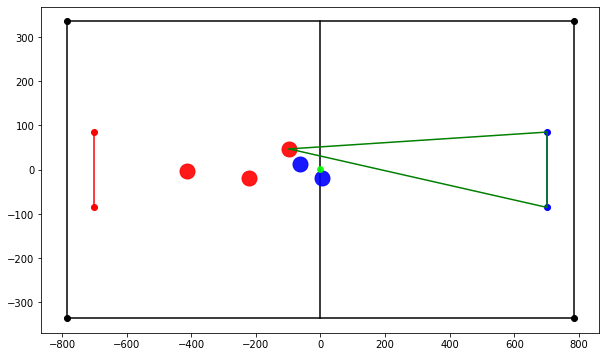

In [36]:
meta = metadata[231]
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
match = load_match(infile)
stadium = stadiums[meta["stadium"]]
goals = list(filter(lambda k: k["type"] == "goal",match["kicks"]))
fig,count = defender_cone(match,stadium,goals[0])
print(count)
print(goals[0])
fig.set_size_inches(10,6)
fig 

In [60]:
def generate_rows_demo(match, stadium):
    """
    Generates target and features for each kick in the match.
    Produces two features for demo classifiers:
        goal_distance: Distance from where  ball was kicked to goal midpoint.
        goal_angle: Angle (in radians) between straight shot from where ball was
            kicked to goal midpoint.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
    Returns:
        Generator of dicts with values for each kick in the given match.
        Includes prediction target "ag" (actual goals) which is 1 for a scored
        goal (goal or error) and 0 otherwise, "index" which is the index of the
        kick in the match kick list, and all the other features needed for
        prediction and explanation.
    """
    for i, kick in enumerate(match["kicks"]):
        gp = get_opposing_goalpost(stadium, kick["fromTeam"])
        x = kick["fromX"]
        y = kick["fromY"]
        gx = gp["mid"]["x"]
        gy = gp["mid"]["y"]
        dist = stadium_distance(x, y, gx, gy)
        angle = angle_from_goal(x, y, gx, gy)
        closest_defender,defender_within = defender_feature(match,kick,100)
        defenders_box = defender_box(match,stadium,kick)
        row = {
            "ag": 1 if is_scored_goal(kick) else 0,
            "index": i,
            "time": kick["time"],
            "x": x,
            "y": y,
            "goal_x": gx,
            "goal_y": gy,
            "goal_distance": dist,
            "goal_angle": angle,
            "team": kick["fromTeam"],
            "stadium": match["stadium"],
            "closest_defender": closest_defender,
            "defender_within": defender_within,
            "defenders_box": defenders_box
        }
        yield row

Then, we write one more method to handle efficiently reading the full, inflated match data. This method takes as a callback the `generate_rows_demo(match, stadium)` method. It also has a handy progress bar using the `tqdm` library.

In [61]:
def make_df(metadata, callback, progress=False):
    """
    Transforms match metadata into a DataFrame of records for
    each kick, including target label and features.
    Args:
        metadata: Match metadata (list of dicts).
        callback: Method to run on each match to extract kicks.
        progress: Whether or not to show progress bar (boolean).
    Returns:
        DataFrame where each row is a kick record.
    """
    rows = []
    bar = tqdm(metadata) if progress else metadata
    for meta in bar:
        key = meta["match_id"]
        infile = "../data/packed_matches/{}.json".format(key)
        try:
            s = stadiums[meta["stadium"]]
            row_gen = load_match(infile, lambda m: callback(m, s))
            for row in row_gen:
                row["match"] = key
                rows.append(row)
        except FileNotFoundError:
            pass
    return pd.DataFrame(rows)

In [62]:
d_train = make_df(train, generate_rows_demo, progress=True)
d_test = make_df(test, generate_rows_demo, progress=True)

100%|██████████| 393/393 [00:28<00:00, 13.85it/s]


## Evaluate Model

Now we can use scikit-learn to train and evaluate a demo model. We will use a logistic regression classifier. It will take in the two features we extraced (goal distance and goal angle) and predict an XG value in the range of [0, 1].

Normally, if a binary classifier outputs a predicted probability greater than 0.5, the predicted label will be true. However, we know that a very small fraction of kicks results in goals, so we may choose an even higher threshold.

For this imbalanced prediction task, accuracy will not be a very useful metric. Precision and recall are helpful, but they focus on binary labels. For XG, we want to calibrate the predicted probability so that higher quality opportunities have higher values, even if they don't result in scored goals.

What metrics and techniques can we use to evaluate whether our XG models are fit for the task?

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

In [120]:
def summarize_model(yt, yp):
    """
    Helper method to summarize some prediction metrics.
    Args:
        yt: Array of true scored goal values.
        yp: Array of predicted scored goal values.
    """
    print("Accuracy = {:.3f}".format(accuracy_score(yt, yp)))
    print("Precision = {:.3f}".format(precision_score(yt, yp)))
    print("Recall    = {:.3f}".format(recall_score(yt, yp)))
    print("ROC AUC   = {:.3f}".format(roc_auc_score(yt, yp)))
    
    #when comparing values
    #precision = precision_score(yt, yp)
    #roc = roc_auc_score(yt, yp)
    #return precision,roc

In [121]:
features = ["closest_defender","goal_distance","goal_angle"]
X_train = d_train[features]
y_train = d_train["ag"]
X_test = d_test[features]
y_test = d_test["ag"]
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [125]:
def model_features(features,classifier,kwargs):
    X_train = d_train[features]
    y_train = d_train["ag"]
    X_test = d_test[features]
    y_test = d_test["ag"]
    clf = classifier(**kwargs)
    clf.fit(X_train, y_train)
    #print("Train Scores:")
    #summarize_model(y_train, clf.predict(X_train))
    #print()
    print("Test Scores:")
    summarize_model(y_test, clf.predict(X_test))
    return clf

In [126]:
features = ["closest_defender","defender_within","goal_distance","goal_angle","defenders_box"]
clf = model_features(features, LogisticRegression, {"random_state": 0})
clf

Test Scores:
Accuracy = 0.965
Precision = 0.488
Recall    = 0.018
ROC AUC   = 0.509


LogisticRegression(random_state=0)

In [127]:
features = ["closest_defender","defender_within","goal_distance"]
clf = model_features(features, LogisticRegression, {"random_state": 0})
clf

Test Scores:
Accuracy = 0.966
Precision = 0.500
Recall    = 0.001
ROC AUC   = 0.500


LogisticRegression(random_state=0)

In [128]:
from itertools import chain, combinations

features = ["closest_defender","defender_within","goal_distance","goal_angle","defenders_box"]

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(3,len(s)+1))

results = list(powerset(features))
max_pre = 0
max_roc = 0
for res in results:
    feat = list(res)
    #clf = model_features(feat, GradientBoostingClassifier, {"n_estimators":100, "learning_rate":1.0,"max_depth":1, "random_state":0})

    # easy way to check all combinations
    # with distance within set to 100, the best model based on precision is all 4 feature
    # ['goal_distance', 'goal_angle', 'defenders_box']
    #['closest_defender', 'defender_within', 'goal_distance', 'goal_angle', 'defenders_box']

In [89]:
from sklearn.neighbors import KNeighborsClassifier
features = ["closest_defender","defender_within","goal_distance","goal_angle","defenders_box"]
clf = model_features(features, KNeighborsClassifier, {"n_neighbors": 4})
clf

Test Scores:
Precision = 0.447
ROC AUC   = 0.522


KNeighborsClassifier(n_neighbors=4)

In [94]:
from sklearn.linear_model import SGDClassifier
features = ["closest_defender","defender_within","goal_distance","goal_angle","defenders_box"]
clf = model_features(features, SGDClassifier, {"loss": "hinge", "penalty":"l2", "max_iter":25})
clf

Test Scores:
Precision = 0.330
ROC AUC   = 0.556


/home/ezfire/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(max_iter=25)

In [129]:
from sklearn.ensemble import GradientBoostingClassifier
features = ["closest_defender","defender_within","goal_distance","goal_angle","defenders_box"]
clf = model_features(features, GradientBoostingClassifier, {"n_estimators":100, "learning_rate":1.0,"max_depth":1, "random_state":0})
clf

Test Scores:
Accuracy = 0.966
Precision = 0.564
Recall    = 0.056
ROC AUC   = 0.527


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
features = ["goal_distance","goal_angle","defenders_box"]
clf = model_features(features, GradientBoostingClassifier, {"n_estimators":100, "learning_rate":1.0,"max_depth":1, "random_state":0})
clf

Test Scores:
Accuracy = 0.966
Precision = 0.602
Recall    = 0.048
ROC AUC   = 0.523


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

While traditional evaluation metrics focus on the record-level, we also want to aggregate the XG scores to the match level and compare the actual scored goals to our XG for each team.

We could also aggregate XG by player, or compare offensive XG to allowed goals for defensive analysis.

In [131]:
p_test = clf.predict_proba(X_test)[:,1]
df_results = pd.DataFrame(d_test)
df_results["xg"] = p_test
df_results.groupby(["match", "team"])[["ag", "xg"]].sum().head(10)

ag        xg
match                team              
-MOTVkwbfE_IKa15MVn9 blue   1  0.174912
                     red    2  0.483423
-MOy-f6_nveB6alhv7BD red    1  0.098711
-MOy0mtEf9VvJLYeb9g_ red    1  0.050504
-MOy1YNMaXX-VaR3ROtD red    1  0.038484
-MOy_8TXdyiIYo9ty5Zu blue   0  0.696178
                     red    2  3.585762
-MOy_aJlP-DUs6MyaR1N blue   2  0.384838
                     red    3  2.367942
-MOybwFHeoLse3Kyjf3h red    1  0.038484

## Save Model

This demo model is unrefined, and by the measures we briefly looked at, it's not good. Still, it gives us a place to start from.

We can use `joblib` to save this model. We will commit this model to our repository. If you have in-progress models, write those to a folder you have gitignored to avoid committing them.

We can now use this model in our server to produce on-demand predictions for new matches. The helper function `predict_xg(match, stadium, clf)` takes the new match, the stadium data, and our stored classifier and then augments the match response with XG predictions.

We will also save the new methods we wrote in this notebook so we can use them in our server as well. Common utility functions will go in `haxml/utils.py` and data preparation and prediction functions will go in `haxml/prediction.py`.

In [ ]:
import joblib

joblib.dump(clf, "../models/demo_logistic_regression.pkl")

In [ ]:
def predict_xg_demo(match, stadium, generate_rows, clf):
    """
    Augments match data with XG predictions.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
        generate_rows: function(match, stadium) to generate kick records.
        clf: Classifier following scikit-learn interface.
    Returns:
        Inflated match data with "xg" field added to each kick (dict).
    """
    features = ["goal_distance", "goal_angle"]
    d_kicks = pd.DataFrame(generate_rows(match, stadium))
    d_kicks["xg"] = clf.predict_proba(d_kicks[features])[:,1]
    for kick in d_kicks.to_dict(orient="records"):
        match["kicks"][kick["index"]]["xg"] = kick["xg"]
    return match

In [ ]:
test_meta = test[45]
s = stadiums[test_meta["stadium"]]
demo_clf = joblib.load("../models/demo_logistic_regression.pkl")
test_match = load_match(
    "../data/packed_matches/{}.json".format(test_meta["match_id"]),
    lambda m: predict_xg_demo(m, s, generate_rows_demo, demo_clf)
)
test_meta

In [ ]:
pd.DataFrame(test_match["kicks"]).query("type == 'goal'").head()